In [1]:
# import ost
# os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
import numpy as np

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras import models,layers

In [5]:
import matplotlib.pyplot as plt

In [ ]:
image_size = 128
batch_size =32
epochs =150

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "imagesdataset",
    image_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=True
)


Found 15018 files belonging to 38 classes.


In [9]:
class_names = dataset.class_names
class_names

['apple_pie',
 'bread_pudding',
 'carrot_cake',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'club_sandwich',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'eggs_benedict',
 'fish_and_chips',
 'french_fries',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'grilled_cheese_sandwich',
 'hamburger',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'omelette',
 'onion_rings',
 'pancakes',
 'pizza',
 'red_velvet_cake',
 'risotto',
 'samosa',
 'spring_rolls',
 'strawberry_shortcake',
 'waffles']

In [10]:
len(dataset)

470

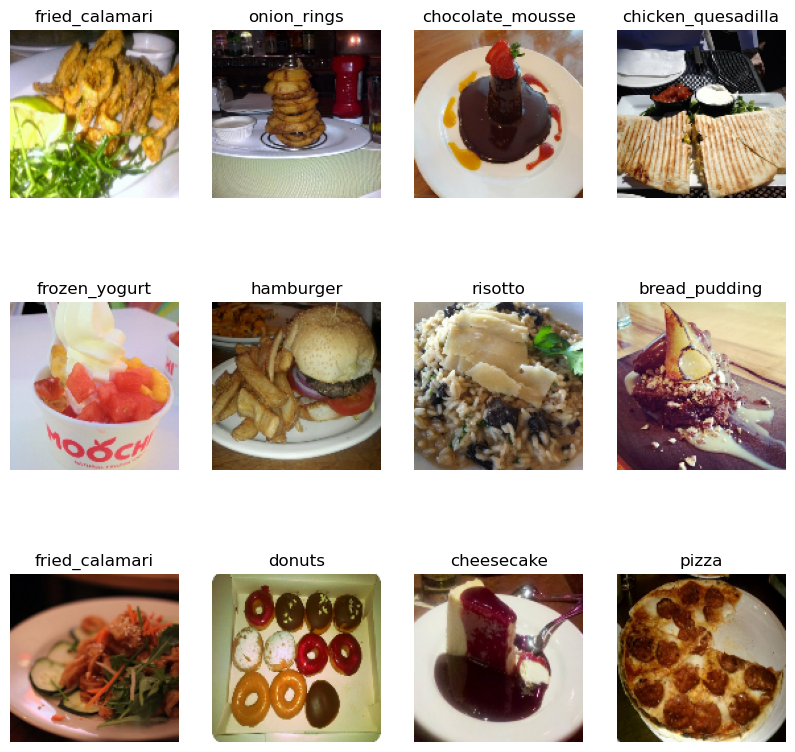

In [11]:
plt.figure(figsize=(10,10))
for image_batch, lable_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[lable_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)

470

In [13]:
#80% => train
#20% => 10% - test , 10% - validate

In [14]:
def dataset_partitions_tf(ds,train_split=0.8,test_split=0.1,valid_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=6)

    train_size = int(ds_size*train_split)
    valid_size = int(ds_size*valid_split)

    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)
    return train_ds,test_ds,valid_ds

In [15]:
train_ds,test_ds,valid_ds = dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

376

In [17]:
len(test_ds)

47

In [18]:
len(valid_ds)

47

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [20]:
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
# Resize and rescale
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1.0/255)
])

In [23]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

In [24]:
n_classes = len(class_names)

In [34]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(image_size, image_size, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # freeze backbone

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation="softmax")
])


In [26]:
# Build model (correct input shape)
model.build(input_shape=(None, image_size, image_size, 3))

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [29]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",        # watch validation loss
        patience=10,               # stop if no improvement for 10 epochs
        restore_best_weights=True  # keep best weights
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",        # watch validation loss
        factor=0.5,                # reduce LR by 50 percentage
        patience=5,                # wait 5 epochs before reducing
        min_lr=1e-6                # don’t let LR go below this
    )
]

In [30]:
# Train
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=valid_ds,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 157s 328ms/step - accuracy: 0.0637 - loss: 3.9579 - val_accuracy: 0.1755 - val_loss: 3.1632 - learning_rate: 1.0000e-04
Epoch 2/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 104s 277ms/step - accuracy: 0.1590 - loss: 3.2557 - val_accuracy: 0.2879 - val_loss: 2.6795 - learning_rate: 1.0000e-04
Epoch 3/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 148s 293ms/step - accuracy: 0.2366 - loss: 2.8769 - val_accuracy: 0.3650 - val_loss: 2.4082 - learning_rate: 1.0000e-04
Epoch 4/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 138s 281ms/step - accuracy: 0.2828 - loss: 2.6666 - val_accuracy: 0.4116 - val_loss: 2.2228 - learning_rate: 1.0000e-04
Epoch 5/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 105s 279ms/step - accuracy: 0.3192 - loss: 2.5048 - val_accuracy: 0.4415 - val_loss: 2.0933 - learning_rate: 1.0000e-04
Epoch 6/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 105s 280ms/step - accuracy: 0.3475 - loss: 2.3842 - val_accuracy: 0.4641 - val_loss: 2.0000 - learning_rate: 1.0000e-04
Epoch 7/150
376/376 ━━━━━━━━━━━━━━

In [31]:
scores = model.evaluate(test_ds)

47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.6137 - loss: 1.3344


In [32]:
model_version = 9
model.export(f"../foodmodels/{model_version}")
model.save("../foodmodels/final1.keras")

INFO:tensorflow:Assets written to: ../foodmodels/9\assets


INFO:tensorflow:Assets written to: ../foodmodels/9\assets


Saved artifact at '../foodmodels/9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 38), dtype=tf.float32, name=None)
Captures:
  2152945768336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152945770064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152945769872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152945770448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152904779792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152945770640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152945771792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152945771984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152945770832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152945771408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2152945772560: TensorSpec(shap